# Predictive power for thrombus detection after atrial appendage closure: machine learning vs. classical methods

## Import libraries

In [1]:
# Data handling
import pandas as pd
import numpy as np

# Stadistics
from scipy.stats import chi2_contingency,mannwhitneyu, ttest_ind, levene, wilcoxon
import statsmodels
import statsmodels.api as sm

# Machine Learning
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import roc_auc_score, precision_score, recall_score, confusion_matrix, roc_curve, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

# Visualization
import plotnine as p9
from plotnine import ggplot, aes, geom_bar, geom_col, geom_dotplot, geom_boxplot, geom_pointrange, geom_linerange, geom_errorbar, geom_point, geom_jitter, geom_segment, geom_smooth, geom_line, geom_text
from plotnine import theme, coord_flip,element_blank, scale_fill_manual, scale_x_discrete, scale_x_continuous, scale_y_continuous, element_line, labs, scale_color_identity, element_text

# Notebooks options
%pylab inline
pd.options.display.max_columns = None
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


## Load data

In [2]:
df = pd.read_excel("/home/ubuntu/TROMIA/data_proc/data_clean_final.xlsx")
df.shape

(1150, 265)

## Model variables
These variables have been selected after cleaning and preprocessing the database.

In [3]:
vars_model = ['age', 'gender', 'weight', 'height', 'bmi', 'bsa', 'hta', 'diabetes', 'smoking',
              'fa_type_1.0', 'fa_type_2.0', 'atrial_flutter', 'priorstroke', 'priorhemorrhagicstroke',
              'prior_tia', 'prior_systemic_embolization_all', 'prior_peripheral_embolization',
              'prior_heart_failure', 'prior_vascular_disease', 'previous_cad', 'previous_mi',
              'previous_pci', 'previous_cabg', 'prior_valvsurgery_description_grouped_1',
              'prior_valvsurgery_description_grouped_2', 'prior_valvsurgery_description_grouped_3',
              'chads2', 'chads2-vasc', 'has-bled', 'creatclcockroft_new', 'insuficiencia_renal_grave',
              'prior_dialysis', 'liver_disease_clean', 'prior_bleeding_clean',
              'priorbleeding_number_of_episodes', 'labile_inr_clean', 'alcohol',
              'chronicnsaiduse', 'prior_high_risk_falls_clean', 'pre_aas', 'pre_adp_inhibitor',
              'pre_coumadin_warfarin', 'pre_othersanticoag', 'pre_e_lvef', 'pre_severe_mitral_regurgitation',
              'pre_severe_mitral_stenosis', 'procedure_anesthesia', 'procedural_tee', 'procedure_combined',
              'procedure_reposition_(if_available)', 'procedure_rhythm', 'procedure_contrast',
              'laa_morphology_comb_1.0', 'laa_morphology_comb_2.0', 'laa_morphology_comb_3.0',
              'laa_morphology_comb_4.0', 'laa_morphology_comb_5.0', 'laa_closure_device_size',
              'laa_closure_device_number', 'procedure_complications', 'pr_comp_other',
              'pr_comp_major_bleeding', 'pr_comp_major_vascular_complications', 'pr_comp_device_embolization',
              'pr_comp_cardiac_tamponade', 'h_days', 'h_stroke', 'h_systemic_embolism', 'h_pericardialefussion',
              'h_dialysis', 'd_asa', 'd_adp_inhibitor', 'd_coumadin_warfarin', 'd_otheranticoag', 'd_enoxaparin',
              'complete_occlusion']

## Functions

- Specificity
- Univariate test
- Multivariable test
- Classical Feature Selection

### specificity

In [4]:
def specificity(y_true, y_pred):
    '''This function calculates the specificty of the model
    Args:
        y_true: Array of the label to be predicted
        y_pred: Array of the label predicted by the model
    Returns:
        Specificity
    '''
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn+fp)

### Univariate test

In [5]:
# Univariate test > Lists of variables.
var_UM = ['chads2', 'chads2-vasc', 'has-bled']
var_tT = [var for var in [v for v in vars_model if len(df[v].value_counts())>2] if var not in var_UM]
var_c2 = [var for var in vars_model if var not in [v for v in vars_model if len(df[v].value_counts())>2]]

variables_d = {'UM' : var_UM, 'tT' : var_tT, 'chi2' : var_c2}

In [6]:
# Univariate tests
def chi2(df, v, y):
    '''chi2 test calculation
    Args:
        df: Dataframe of data
        v: name of the column to be tested on
        y: name of class variable
    Returns:
        p-value result of chi2 test
    '''
    return chi2_contingency(pd.crosstab(df[v],y))[1]

def umw(df, v, y):
    '''Mann–Whitney U test calculation
    Args:
        df: Dataframe of data
        v: name of the column to be tested on
        y: name of class variable
    Returns:
        p-value result of Mann–Whitney U test
    '''
    return mannwhitneyu(df[v],y)[1]

def ttest(df, v, y):
    '''t-test calculation
    Args:
        df: Dataframe of data
        v: name of the column to be tested on
        y: name of class variable
    Returns:
        p-value result of t-test
    '''
    return ttest_ind(df.loc[y==0,v],df.loc[y==1,v])[1]

### Multivariable test

In [7]:
def mult_lr(df, vals, y):
    '''multivariable test calculation using the logistic regression model 
    Args:
        df: Dataframe of data
        vals: array with the name of the columns to be tested on
        y: name of class variable
    Returns:
        p-value result of multivaiable test
    '''
    try:
        mod = sm.Logit(y, df[vals]).fit()
        return mod
    except (LinAlgError, ValueError):
        pass

### Classical Feature Selection
- Univariate pvalue < 0.05 --> multivariable model
- Multivariable pvalue < 0.05 --> final model

Igual que lo que he comentado antes. También intenta usar el mismo vocabulario que el paper

In [8]:
# Classic Method Feature selection: Univariate test + Multivariable test.
def feat_sel(df, variables_d, y, pv=0.05):
    '''Multivariable feature selection calculation
    Args:
        df: Dataframe of data
        variables_d: array with the name of the columns to be tested on
        y: name of class variable
        pv: cut-off point of the p-value to be significant
    Returns:
        variables: array of variables significatives on the univariate test
        uni_pvs: pvalues obtained of univariate test
        multr.pvalues.values: pvalues obtained of multivariable test
    '''
    variables = []
    uni_pvs = []
    for k in variables_d.keys():
        if k == 'UM':
            variables = variables + [var for var in variables_d[k] if umw(df, var, y)<pv]
            uni_pvs = uni_pvs + [umw(df, var, y) for var in variables_d[k] if umw(df, var, y)<pv]
        elif k == 'tT':
            variables = variables + [var for var in variables_d[k] if ttest(df, var, y)<pv]
            uni_pvs = uni_pvs + [ttest(df, var, y) for var in variables_d[k] if ttest(df, var, y)<pv]
        elif k == 'chi2':
            variables = variables + [var for var in variables_d[k] if chi2(df, var, y)<pv]
            uni_pvs = uni_pvs + [chi2(df, var, y) for var in variables_d[k] if chi2(df, var, y)<pv]
    
    if variables==[]:
        pass
    else:
        multr = mult_lr(df, variables, y)

    return variables, uni_pvs, multr.pvalues.values

## Experiments

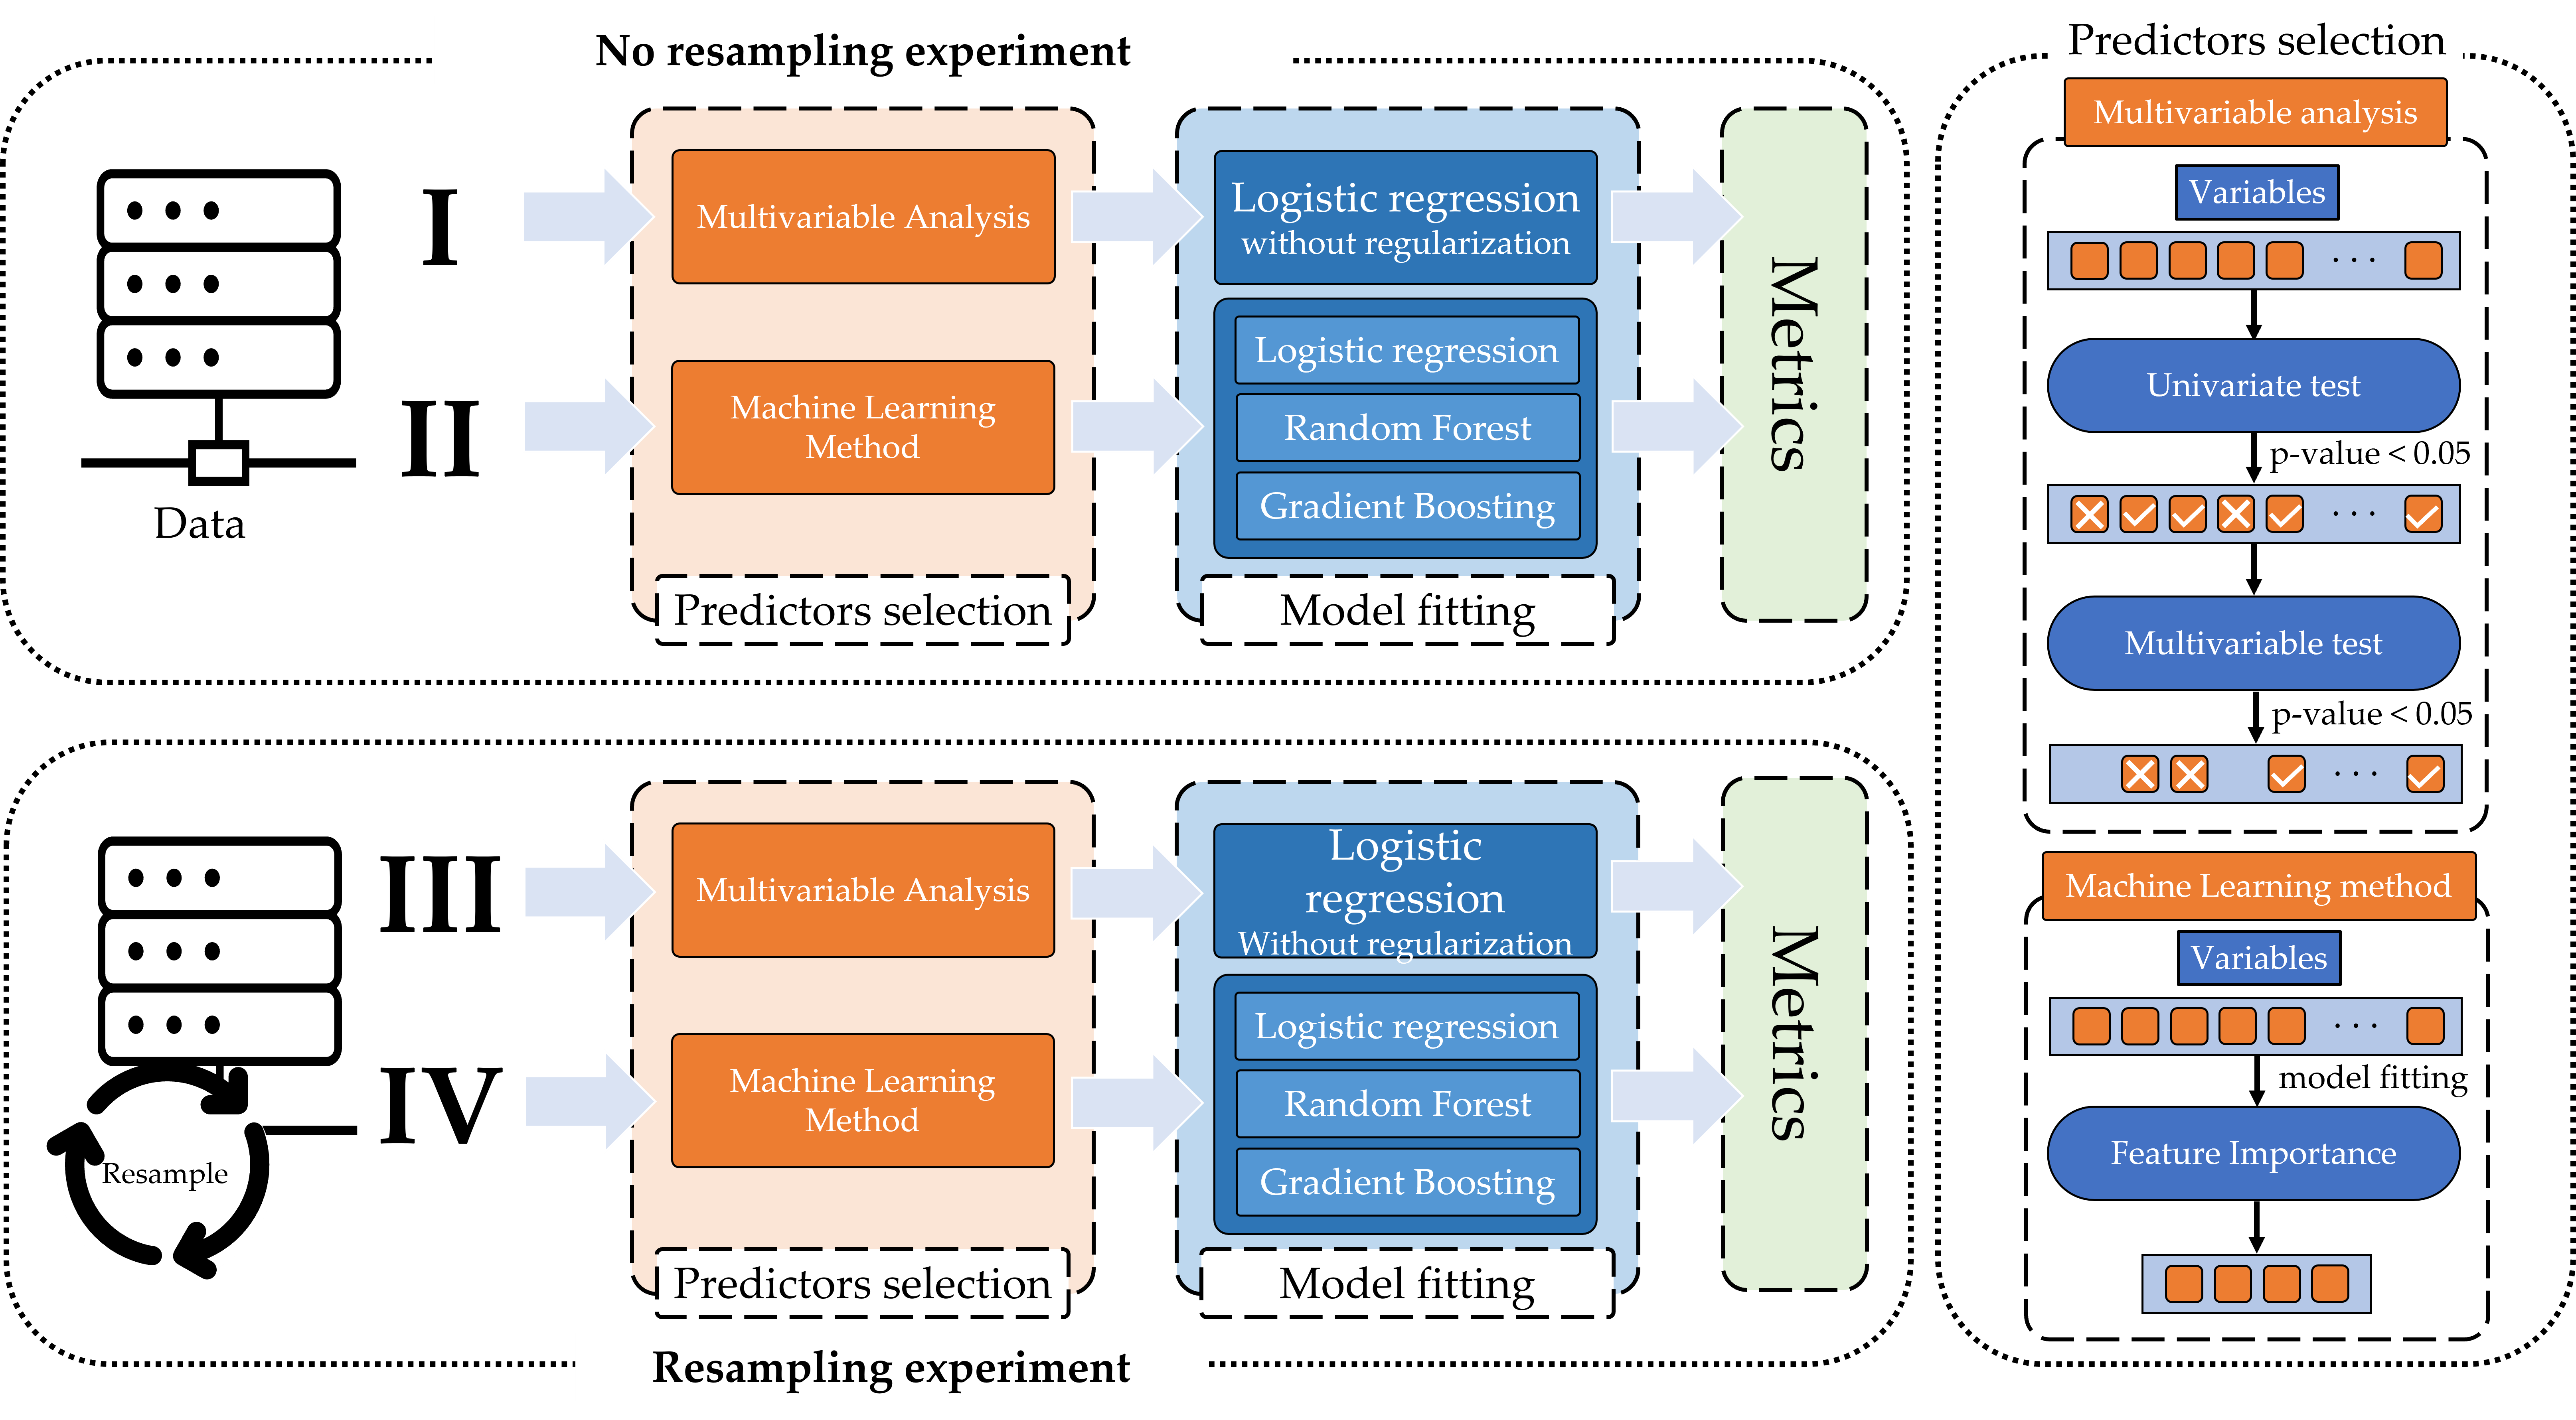

### Experiment I

In [9]:
df['last_fu_tee_thrombus'].value_counts()

0.0    778
1.0     35
Name: last_fu_tee_thrombus, dtype: int64

In [10]:
endpoint = "last_fu_tee_thrombus"

inds = df[endpoint].isna()==False
X = df.loc[inds,vars_model]
Y = df.loc[inds,endpoint]

#### Feature Selection

In [11]:
df_classic_sel = pd.DataFrame()
df_classic_sel['var'], df_classic_sel['unipv'], df_classic_sel['mulpv'] = feat_sel(X, variables_d, Y)

Optimization terminated successfully.
         Current function value: 0.187541
         Iterations 7


In [12]:
df_classic_sel

,var,unipv,mulpv
0,chads2,2.300891e-295,0.852333
1,chads2-vasc,8.293644e-300,0.414200
2,has-bled,4.045919e-302,0.000003


#### Model fitting

In [13]:
model_exp_I = sm.Logit(Y, X['has-bled']).fit()
pred_exp_I = model_exp_I.predict(X['has-bled'])

Optimization terminated successfully.
         Current function value: 0.188760
         Iterations 7


#### Results

In [14]:
fpr, tpr, thresholds = roc_curve(Y, pred_exp_I)
ROC_scores = []
for thresh in thresholds:
    ROC_scores.append(roc_auc_score(Y, [m > thresh for m in pred_exp_I]))

ROCs = np.array(ROC_scores)
max_recall = ROCs.max() 
pc =  thresholds[ROCs.argmax()]

In [15]:
print('Cut-off point:\t',pc,
      '\nAUC:\t\t',roc_auc_score(Y, pred_exp_I),
      '\nSensibility:\t',recall_score(Y, np.array([1 if p>pc else 0 for p in pred_exp_I])),
      '\nSpecificity:\t',specificity(Y, np.array([1 if p>pc else 0 for p in pred_exp_I])))

Cut-off point:	 0.01271419051420868 
AUC:		 0.5456298200514139 
Sensibility:	 0.8857142857142857 
Specificity:	 0.21979434447300772


### Experiment II

In [16]:
endpoint = "last_fu_tee_thrombus"
seed = 0
lr = LogisticRegression(class_weight="auto", random_state=seed, penalty='l2', C=1.75)
inds = df[endpoint].isna() == False

X = df.loc[inds,vars_model]
Y = df.loc[inds,endpoint]

#### Feature selection

In [17]:
selector = SelectFromModel(estimator=lr).fit(X, Y)

In [18]:
print(list(selector.get_feature_names_out()))

['diabetes', 'fa_type_2.0', 'priorstroke', 'prior_heart_failure', 'prior_vascular_disease', 'previous_cad', 'previous_mi', 'previous_pci', 'prior_valvsurgery_description_grouped_3', 'has-bled', 'insuficiencia_renal_grave', 'prior_dialysis', 'priorbleeding_number_of_episodes', 'labile_inr_clean', 'prior_high_risk_falls_clean', 'pre_aas', 'pre_adp_inhibitor', 'pre_coumadin_warfarin', 'pre_othersanticoag', 'pre_severe_mitral_regurgitation', 'procedure_anesthesia', 'procedure_combined', 'procedure_reposition_(if_available)', 'procedure_rhythm', 'laa_morphology_comb_1.0', 'laa_morphology_comb_2.0', 'd_adp_inhibitor']


#### Model fitting

In [19]:
X_new = selector.transform(X)

model_exp_I = lr.fit(X_new, Y)

pred_exp_I = model_exp_I.predict_proba(X_new)

#### Results

In [20]:
fpr, tpr, thresholds = roc_curve(Y, pred_exp_I[:,1])
ROC_scores = []
for thresh in thresholds:
    ROC_scores.append(roc_auc_score(Y, [m > thresh for m in pred_exp_I[:,1]]))

ROCs = np.array(ROC_scores)
max_recall = ROCs.max() 
pc =  thresholds[ROCs.argmax()]

In [21]:
print('Cut-off point:\t',pc,
      '\nAUC:\t\t',roc_auc_score(Y, pred_exp_I[:,1]),
      '\nSensibility:\t',recall_score(Y, np.array([1 if p>pc else 0 for p in pred_exp_I[:,1]])),
      '\nSpecificity:\t',specificity(Y, np.array([1 if p>pc else 0 for p in pred_exp_I[:,1]])))

Cut-off point:	 0.061768296403819575 
AUC:		 0.7974476680132208 
Sensibility:	 0.6857142857142857 
Specificity:	 0.7776349614395887


##### Predictor selection graph based on the variable weights

In [22]:
coefs = model_exp_I.coef_[0]

DF_weights_expII = pd.DataFrame()
DF_weights_expII['feats'] = list(selector.get_feature_names_out())
DF_weights_expII['coefs'] = coefs

DF_weights_expII.head()

,feats,coefs
0,diabetes,-0.322669
1,fa_type_2.0,-0.152655
2,priorstroke,0.198027
3,prior_heart_failure,-0.099926
4,prior_vascular_disease,0.678675


In [23]:
a = ['Procedure rhythm', 'Procedure reposition',
     'Procedure combined', 'Procedure anesthesia',
     'Prior stroke', 'Prior bleeding episodes',
     'Prior vascular disease',
     'Prior mitral valvular surgery',
     'Prior high risk falls clean', 'Prior heart failure',
     'Prior dialysis', 'Previous PCI *', 'Previous MI *',
     'Previous CAD *', 'Previus severe mitral regurgitation',
     'Previous others anticoag', 'Previous antiVit K treat-ment', 
     'Previously on ADP inhibitor *', 'Previously on ASA *', 'Labile inr clean',
     'LAA bilobed or multilobe morphlogy *', 'LAA chicken-wing morphlogy *',
     'Severe CKD *', 'HASBLEED', 
     'Permanent AF *', 'Diabetes', 'ADP inhibitor at discharge *']

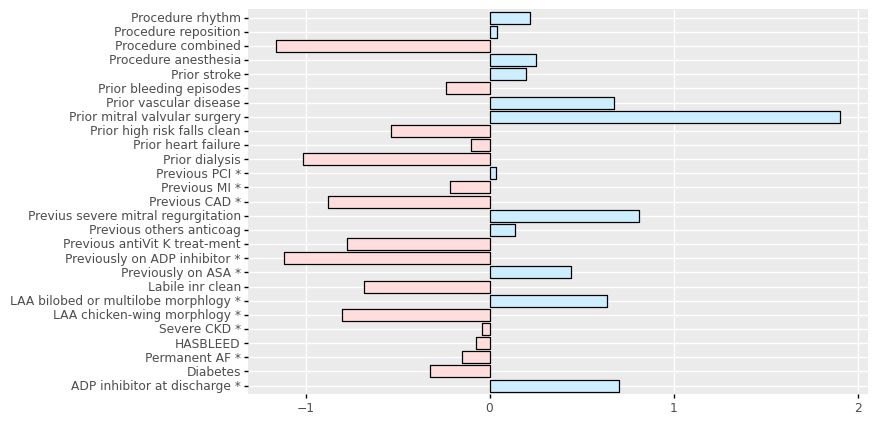

In [24]:
# a = ['procedure rhythm', 'procedure reposition', 'procedure combined', 'procedure anesthesia', 'priorstroke', 'priorbleeding umber of episodes', 'prior vascular disease', 'prior valvsurgery description grouped 3', 'prior high risk falls clean', 'prior heart failure', 'prior dialysis', 'previous pci', 'previous mi', 'previous cad', 'pre severe mitral regurgitation', 'pre othersanticoag', 'pre coumadin warfarin', 'pre adp inhibitor', 'pre aas', 'labile inr clean', 'laa morphology comb = 2', 'laa morphology comb = 1', 'insuficiencia renal grave', 'has-bleed', 'fa type = 2', 'diabetes', 'd adp inhibitor']
# a.sort()

DF_weights_expII['pos'] = False
for i in range(len(DF_weights_expII["coefs"])):
    if DF_weights_expII["coefs"][i] >= 0:
        DF_weights_expII['pos'][i] = True

p9.options.figure_size = (8, 5)

p =ggplot(DF_weights_expII, aes(x="feats", y="coefs", fill="pos")) \
    + geom_col(width = 0.85, colour = "black") \
    + coord_flip() \
    + theme(panel_grid_minor = element_blank(),
            axis_title_y= element_blank(),
            axis_title_x= element_blank()) \
    + scale_fill_manual(values = ["#FFDDDD","#CCEEFF"], guide = False) \
    + scale_x_discrete(labels= a[::-1])

p.save("./Graphics/new/Features_weight.png")
p.draw(show=False, return_ggplot=True);

### Experiment III

In [25]:
cvfolds = 2
rep = 5
seed = 0

endpoint = "last_fu_tee_thrombus"

# Generate k-fold
gkf = RepeatedKFold(n_splits=cvfolds, n_repeats= rep, random_state=seed)

#### Feature selection + Modeling by fold

In [26]:
# Generate the RL with a fixed seed
lr = LogisticRegression(random_state=seed)

# Preprare data
inds = df[endpoint].isna() == False

X = df.loc[inds,vars_model]
Y = df.loc[inds,endpoint]

i = 0
results = {}

# Training for each k-fold
for train_index, test_index in gkf.split(X,Y):
    i+=1
    fold = '{} fold'.format(i)
    result = {}
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

    # Feature selection (univariate + multivariable test)
    if feat_sel(X_train,variables_d,Y_train) is not None:
        variables, unipvs, mulpvs = feat_sel(X_train,variables_d,Y_train)
    else:
        pass
    result['variables'] = variables
    result['pv uni'] = unipvs
    result['pv mul'] = mulpvs
    
    variables_multi = [variables[i] for i, pv in enumerate(mulpvs) if pv<0.05]

    # Perform the training of the RL
    if variables_multi!=[]:
        model = lr.fit(X_train[variables_multi], Y_train)
        ## cut-off short
        prtr = model.predict_proba(X_train[variables_multi])
        fpr, tpr, thresholds = roc_curve(Y_train, prtr[:,1])
        ROC_scores = []
        for thresh in thresholds:
            ROC_scores.append(roc_auc_score(Y_train, [m > thresh for m in prtr[:,1]]))

        ROCs = np.array(ROC_scores)
        max_ROC = ROCs.max() 
        pc =  thresholds[ROCs.argmax()]
        
        preds = model.predict_proba(X_test[variables_multi])
        try:
            ## Results
            result['ROC'] = roc_auc_score(Y_test, preds[:,1])
            result['specificity'] = specificity(Y_test, np.array([1 if p>pc else 0 for p in preds[:,1]]))
            result['sensitivity'] = recall_score(Y_test, np.array([1 if p>pc else 0 for p in preds[:,1]]))
        except ValueError:
            pass
    else:
        pass
    results[fold] = result

Optimization terminated successfully.
         Current function value: 0.185406
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185406
         Iterations 8
         Current function value: 0.168137
         Iterations: 35
         Current function value: 0.168137
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.161506
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.161506
         Iterations 8
         Current function value: 0.200208
         Iterations: 35
         Current function value: 0.200208
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.159822
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.159822
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.209034
         Iterations 7
Optimization terminate

In [27]:
df_KFOLD_ExpIII = pd.DataFrame()
for k in results.keys():
    df_temp = pd.DataFrame()
    df_temp['fold'] = [int("".join(filter(str.isdigit, k)))]*len(results[k]['variables'])
    df_temp['variables'] = results[k]['variables']
    df_temp['pv uni'] = results[k]['pv uni']
    df_temp['pv mul'] = results[k]['pv mul']
    if 'ROC' in results[k].keys():
        df_temp['ROC'] = [results[k]['ROC']]*len(results[k]['variables'])
        df_temp['specificity'] = [results[k]['specificity']]*len(results[k]['variables'])
        df_temp['sensitivity'] = [results[k]['sensitivity']]*len(results[k]['variables'])
    else:
        df_temp['ROC'] = [None]*len(results[k]['variables'])
        df_temp['specificity'] = [None]*len(results[k]['variables'])
        df_temp['sensitivity'] = [None]*len(results[k]['variables'])
    df_KFOLD_ExpIII = pd.concat([df_KFOLD_ExpIII,df_temp]).reset_index(drop=True)

In [28]:
df_KFOLD_ExpIII.head()

,fold,variables,pv uni,pv mul,ROC,specificity,sensitivity
0,1,chads2,5.137191e-148,0.798571,0.487755,0.466837,0.533333
1,1,chads2-vasc,7.686717e-150,0.420997,0.487755,0.466837,0.533333
2,1,has-bled,1.209733e-151,0.101143,0.487755,0.466837,0.533333
3,1,procedure_contrast,4.441210e-02,0.007232,0.487755,0.466837,0.533333
4,2,chads2,3.086694e-149,0.826425,0.39987,0.42487,0.45


#### Results

In [29]:
print('AUC:\t\t',df_KFOLD_ExpIII['ROC'].mean(), '±', df_KFOLD_ExpIII['ROC'].std())
print('sensitivity:\t',df_KFOLD_ExpIII['sensitivity'].mean(), '±', df_KFOLD_ExpIII['sensitivity'].std())
print('specificity:\t',df_KFOLD_ExpIII['specificity'].mean(), '±', df_KFOLD_ExpIII['specificity'].std())

AUC:		 0.5174377675325157 ± 0.05313144430438337
sensitivity:	 0.4317712670653847 ± 0.32554478060524655
specificity:	 0.5504116164118849 ± 0.3173163064886925


#### Predictor variation rate graph

In [30]:
df_variation_rate_classic_ExpIII = pd.DataFrame()
for var in df_classic_sel['var']:
    pv_base = df_classic_sel.loc[df_classic_sel['var'] == var, 'mulpv'].values[0]
    df_variation_rate_classic_ExpIII[var] = ((df_KFOLD_ExpIII.loc[df_KFOLD_ExpIII['variables'] == var,'pv mul']-pv_base)/df_KFOLD_ExpIII.loc[df_KFOLD_ExpIII['variables'] == var,'pv mul'].std()).values

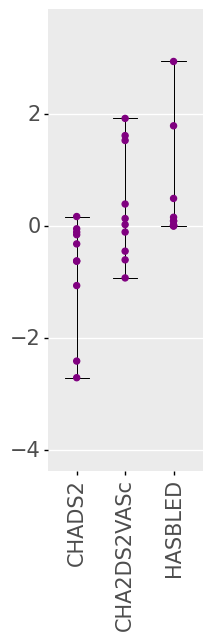

In [31]:
a = ['CHADS2', 'CHA2DS2VASc', 'HASBLED']
df_temp = pd.melt(df_variation_rate_classic_ExpIII)
df_temp['y_min'] = np.nan
df_temp['y_max'] = np.nan
for var in df_temp['variable'].unique():
    df_temp.loc[df_temp['variable']==var,'y_min'] = df_temp.loc[df_temp['variable']==var]['value'].min()
    df_temp.loc[df_temp['variable']==var,'y_max'] = df_temp.loc[df_temp['variable']==var]['value'].max()


p9.options.figure_size = (2, 6)
p = ggplot(df_temp, aes(x= "variable", y="value")) \
    + geom_errorbar(aes(ymin ='y_min', ymax ='y_max'), size = 0.4, alpha = 0.5)\
    + geom_point(color = "purple", alpha=1, size = 2) \
    + p9.scales.ylim(-4,3.5) \
    + theme(axis_text_x = element_text(angle = 90, size = 15),
            axis_text_y = element_text(size = 15),
            panel_grid = element_blank(),
            axis_title_y= element_blank(),
            axis_title_x= element_blank(),
            panel_grid_major_y = element_line(color ="white"))\
    + scale_x_discrete(labels= a)

p.save("./Graphics/new/Graphic_boxplot_Kfold_classic.png")
p.draw(show=False, return_ggplot=True);

#### Occurrences of predictors for each feature selection method

In [32]:
# Function to get the frequency with which a variable appears
def get_freq(slist):
    '''Calculates the frequency at which the variables are chosen.
    Args:
        slist: list with the names of variables.
    Returns:
        Occurrences of predictors for each feature selection method .
    '''
    flatlist = [item for sublist in slist for item in sublist]
    return pd.Series(flatlist).value_counts()

In [33]:
# Vars with p-values significatives on univariate test
get_freq([df_KFOLD_ExpIII['variables']])

chads2                                     10
chads2-vasc                                10
has-bled                                   10
pre_severe_mitral_stenosis                  4
laa_morphology_comb_2.0                     2
procedure_contrast                          1
bmi                                         1
prior_valvsurgery_description_grouped_3     1
h_pericardialefussion                       1
pre_severe_mitral_regurgitation             1
dtype: int64

In [34]:
# Occurrences of predictors on multivariable test
sign_cl = []
for i in range(len(df_KFOLD_ExpIII)):
    if df_KFOLD_ExpIII['pv mul'][i] < 0.05:
        sign_cl.append(df_KFOLD_ExpIII['variables'][i])

print(pd.Series(sign_cl).value_counts())

# pd.Series(sign_cl)
df_temp_cla = pd.DataFrame(sign_cl, columns=['feats'])

has-bled                                   8
procedure_contrast                         1
prior_valvsurgery_description_grouped_3    1
pre_severe_mitral_regurgitation            1
dtype: int64


### Experiment IV

In [35]:
cvfolds = 2
rep = 5
seed = 0

endpoint = "last_fu_tee_thrombus"

# generate k-fold
gkf = RepeatedKFold(n_splits=cvfolds, n_repeats= rep, random_state=seed)

#### Feature selection + Modeling by fold

In [36]:
# Generate the RL with a fixed seed
lr = LogisticRegression(class_weight="auto",random_state=seed, C=1.75)

# Preprare data
inds = df[endpoint].isna() == False

X = df.loc[inds,vars_model]
Y = df.loc[inds,endpoint]

i = 0
results = {}

# Training for each k-fold
for train_index, test_index in gkf.split(X,Y):
    i+=1
    fold = '{} fold'.format(i)
    result = {}
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    
    # Feature selection (SelectFromModel)
    selector = SelectFromModel(estimator=lr).fit(X_train, Y_train)
    X_new = selector.transform(X)

    X_train, X_test = X_new[train_index], X_new[test_index]

    feature_mask = np.array(selector.get_support())
    feature_names = np.array(X.columns.tolist())
    selected_features = list(feature_names[feature_mask])

    # Perform the training of the RL
    model = lr.fit(X_train, Y_train)
    ## cut-off short
    prtr = model.predict_proba(X_train)
    fpr, tpr, thresholds = roc_curve(Y_train, prtr[:,1])
    ROC_scores = []
    for thresh in thresholds:
        ROC_scores.append(roc_auc_score(Y_train, [m > thresh for m in prtr[:,1]]))

    ROCs = np.array(ROC_scores)
    max_ROC = ROCs.max() 
    pc =  thresholds[ROCs.argmax()]
    
    result['feats'] = list(selector.get_feature_names_out())
    result['coefs'] = model.coef_[0]
    
    preds = model.predict_proba(X_test)
    try:
        ## Results
        result['ROC'] = roc_auc_score(Y_test, preds[:,1])
        result['specificity'] = specificity(Y_test, np.array([1 if p>pc else 0 for p in preds[:,1]]))
        result['sensitivity'] = recall_score(Y_test, np.array([1 if p>pc else 0 for p in preds[:,1]]))
    except ValueError:
        pass
    results[fold] = result

In [37]:
df_KFOLD_ExpIV = pd.DataFrame()
for k in results.keys():
    df_temp = pd.DataFrame()
    df_temp['fold'] = [int("".join(filter(str.isdigit, k)))]*len(results[k]['feats'])
    df_temp['feats'] = results[k]['feats']
    df_temp['coefs'] = results[k]['coefs']
    if 'ROC' in results[k].keys():
        df_temp['ROC'] = [results[k]['ROC']]*len(results[k]['feats'])
        df_temp['specificity'] = [results[k]['specificity']]*len(results[k]['feats'])
        df_temp['sensitivity'] = [results[k]['sensitivity']]*len(results[k]['feats'])
    else:
        df_temp['ROC'] = [None]*len(results[k]['feats'])
        df_temp['specificity'] = [None]*len(results[k]['feats'])
        df_temp['sensitivity'] = [None]*len(results[k]['feats'])
    df_KFOLD_ExpIV = pd.concat([df_KFOLD_ExpIV,df_temp])

In [38]:
df_KFOLD_ExpIV.head()

,fold,feats,coefs,ROC,specificity,sensitivity
0,1,diabetes,-1.082764,0.452551,0.836735,0.133333
1,1,fa_type_1.0,0.740557,0.452551,0.836735,0.133333
2,1,prior_systemic_embolization_all,-1.062601,0.452551,0.836735,0.133333
3,1,prior_vascular_disease,1.218528,0.452551,0.836735,0.133333
4,1,previous_cad,-1.127982,0.452551,0.836735,0.133333


#### Results

In [39]:
print('AUC:\t\t',df_KFOLD_ExpIV['ROC'].mean(), '±', df_KFOLD_ExpIV['ROC'].std())
print('sensitivity:\t',df_KFOLD_ExpIV['sensitivity'].mean(), '±', df_KFOLD_ExpIV['sensitivity'].std())
print('specificity:\t',df_KFOLD_ExpIV['specificity'].mean(), '±', df_KFOLD_ExpIV['specificity'].std())

AUC:		 0.5325048793233625 ± 0.03493085393122986
sensitivity:	 0.28035204918164286 ± 0.07707287614858943
specificity:	 0.7634286134994225 ± 0.05176101563325354


#### Predictor variation rate graph

In [40]:
df_variation_rate_ml = {}
for var in DF_weights_expII['feats']:
    coef_base = DF_weights_expII.loc[DF_weights_expII['feats'] == var, 'coefs'].values[0]
    df_variation_rate_ml[var] = ((df_KFOLD_ExpIV.loc[df_KFOLD_ExpIV['feats'] == var,'coefs']-coef_base)/df_KFOLD_ExpIV.loc[df_KFOLD_ExpIV['feats'] == var,'coefs'].std()).values

In [41]:
a = ['ADP inhibitor at discharge *','Diabetes',
     'Permanent AF (atrial fibrillation)',
     'Severe CKD (chronic kidney disease)',
     'LAA chicken-wing morphlogy *',
     'Labile INR','Previously on ASA *','Previosuly on ADP inhibitor *',
     'Baseline non-antiVitK anticoagulants',
     'Previous severe mitral regurgitation',
     'Previos MI (miocardial infarct)',
     'Previous PCI (percutaneous coronary intervention)',
     'Dialysis','Prior HF (heart failure)',
     'Baselin high risk of falls',
     'Previous mitral valve surgery',
     'Prior peripheral vascular disease',
     'Prior bleeding episodes', 'Prior stroke',
     'Procedure anesthesia', 'Combined procedure',
     'Procedural device reposition', 'Procedural rythm']

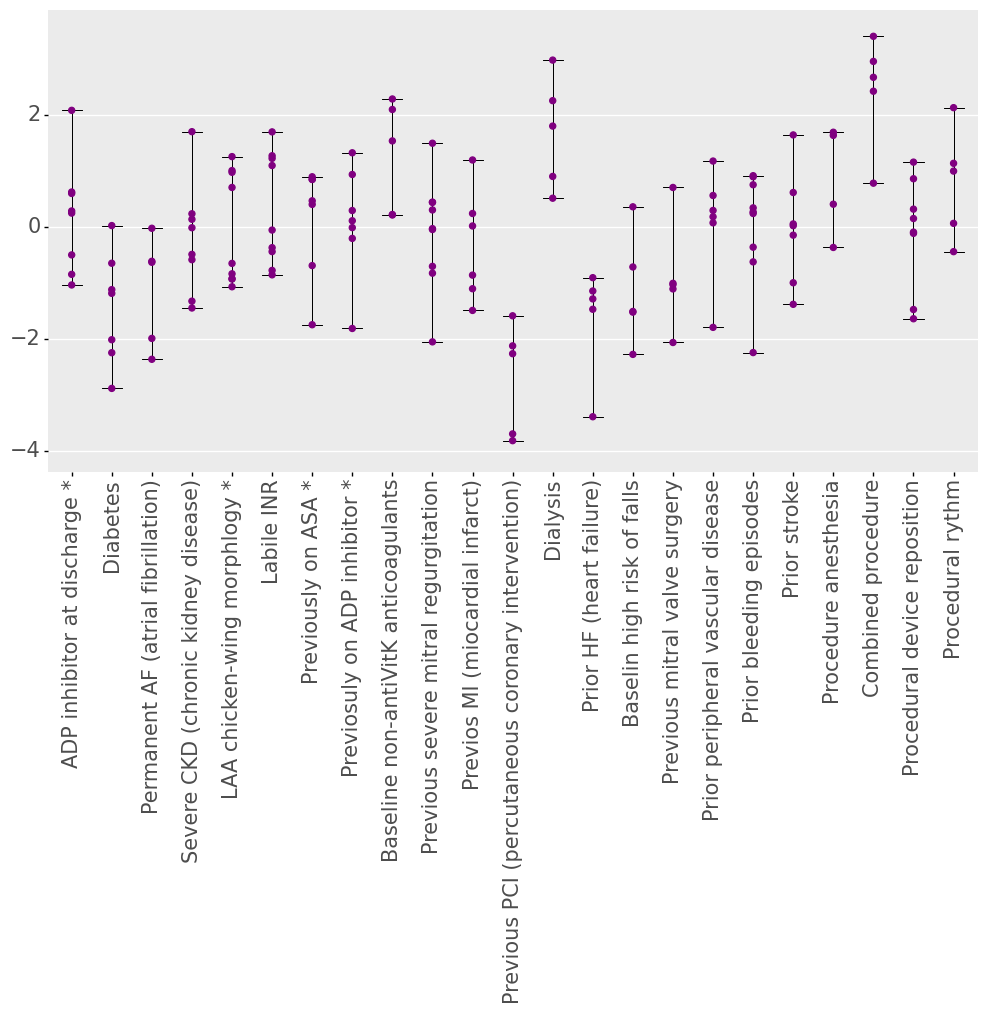

In [42]:
df_ = pd.DataFrame()
for k in df_variation_rate_ml.keys():
    n = len(df_variation_rate_ml[k])
    if n<10:
        df_[k] = list(df_variation_rate_ml[k])+[None]*(10-n)
df_ = df_.drop(labels = ['laa_morphology_comb_2.0'], axis = 1)

df_boxplot_temp = pd.melt(df_)
df_boxplot_temp['y_min'] = np.nan
df_boxplot_temp['y_max'] = np.nan
for var in df_boxplot_temp['variable'].unique():
    df_boxplot_temp.loc[df_boxplot_temp['variable']==var,'y_min'] = df_boxplot_temp.loc[df_boxplot_temp['variable']==var]['value'].min()
    df_boxplot_temp.loc[df_boxplot_temp['variable']==var,'y_max'] = df_boxplot_temp.loc[df_boxplot_temp['variable']==var]['value'].max()

# a = ['procedure rhythm', 'procedure reposition', 'procedure combined', 'procedure anesthesia', 'priorstroke', 'priorbleeding number of episodes', 'prior vascular disease', 'prior valvsurgery description grouped 3', 'prior high risk falls clean', 'prior heart failure', 'prior dialysis', 'previous pci', 'previous mi', 'pre severe mitral regurgitation', 'pre othersanticoag', 'pre adp inhibitor', 'pre aas', 'labile inr clean', 'laa morphology comb = 1', 'insuficiencia renal grave', 'fa type = 2', 'diabetes', 'd adp inhibitor']
# a.sort()

# Revisar el color de este gráfico, es feo :(
p9.options.figure_size = (12, 6)
p = ggplot(df_boxplot_temp, aes(x= "variable", y="value")) \
    + geom_errorbar(aes(ymin ='y_min', ymax ='y_max'), size = 0.4, alpha = 0.5)\
    + geom_point(color = "purple", alpha=1, size = 2) \
    + p9.scales.ylim(-4,3.5) \
    + theme(axis_text_x = element_text(angle = 90, size = 15),
            axis_text_y = element_text(size = 15),
            axis_title_y= element_blank(),
            axis_title_x= element_blank(),
            panel_grid = element_blank(),
            panel_grid_major_y = element_line(color ="white"))\
    + scale_x_discrete(labels= a)

p.save("./Graphics/new/Graphic_boxplot_ml.png")
p.draw(show=False, return_ggplot=True);

#### Occurrences of predictors for each feature selection method

In [43]:
df_KFOLD_ExpIV['feats'].value_counts()

previous_cad                               10
has-bled                                   10
pre_coumadin_warfarin                      10
laa_morphology_comb_1.0                     9
pre_severe_mitral_regurgitation             9
priorbleeding_number_of_episodes            9
labile_inr_clean                            9
d_adp_inhibitor                             8
procedure_reposition_(if_available)         8
insuficiencia_renal_grave                   8
h_pericardialefussion                       8
diabetes                                    7
priorstroke                                 7
pre_adp_inhibitor                           7
pre_aas                                     7
prior_systemic_embolization_all             7
chads2-vasc                                 6
chads2                                      6
prior_vascular_disease                      6
previous_mi                                 6
priorhemorrhagicstroke                      6
prior_tia                         

# Statistical tests to assess the difference between predictor variation rate of experiments III and IV

In [44]:
# values of predictor variation rate of experiment III
L = [list(df_variation_rate_classic_ExpIII[col].values) for col in df_variation_rate_classic_ExpIII.columns]
v_classic = np.array([item for sublist in L for item in sublist])

In [45]:
# values of predictor variation rate of experiment IV
L = [list(df_variation_rate_ml[k]) for k in df_variation_rate_ml.keys()]
v_ML = np.array([item for sublist in L for item in sublist])

### Levene test
This test was used to assess the equality of variances between the experiments III and IV

In [46]:
levene(v_ML, v_classic)

LeveneResult(statistic=4.305267670660416, pvalue=0.03921893449773263)

p-value < 0.05. There is no equality between the variances.

### Mann Whitney U
This test was used to assess the indepency between the experiments III and IV

In [47]:
mannwhitneyu(v_ML, v_classic)

MannwhitneyuResult(statistic=2690.0, pvalue=0.9369512902171293)

p-value > 0.05. The experiments III and IV are independent of each other.

## Results comparation

### ROC AUC between experiments III and IV

In [48]:
df_ROC = pd.DataFrame()
df_ROC['Exp III'] = df_KFOLD_ExpIII.ROC.unique()
df_ROC['Exp IV'] =df_KFOLD_ExpIV.ROC.unique()

df_ROC = df_ROC.astype('float64')
df_ROC = pd.melt(df_ROC)

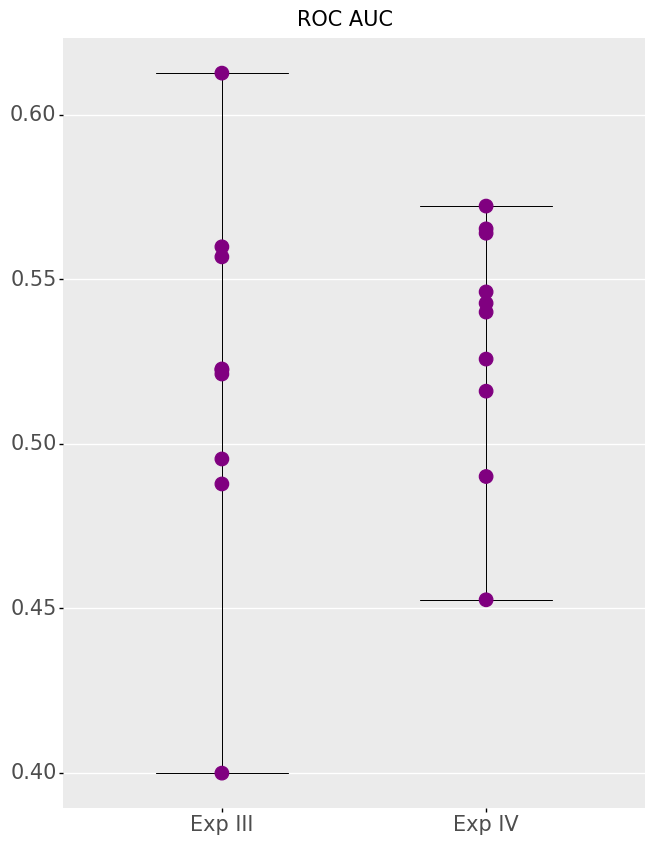

In [49]:
df_ROC_temp = df_ROC.copy()
df_ROC_temp['y_min'] = np.nan
df_ROC_temp['y_max'] = np.nan
for var in df_ROC_temp['variable'].unique():
    df_ROC_temp.loc[df_ROC_temp['variable']==var,'y_min'] = df_ROC_temp.loc[df_ROC_temp['variable']==var]['value'].min()
    df_ROC_temp.loc[df_ROC_temp['variable']==var,'y_max'] = df_ROC_temp.loc[df_ROC_temp['variable']==var]['value'].max()
    
# Revisar el color de este gráfico, es feo :(
p9.options.figure_size = (7.5, 10)
p = ggplot(df_ROC_temp, aes(x= "variable", y="value")) \
    + geom_errorbar(aes(ymin ='y_min', ymax ='y_max'), size = 0.3, alpha = 0.5)\
    + geom_point(color = "purple", size = 5, alpha=1) \
    + theme(axis_text_x = element_text(size = 15),
            axis_title_x= element_blank(),
            axis_text_y = element_text(size = 15),
            axis_title_y= element_blank(),
            panel_grid = element_blank(),
            panel_grid_major_y = element_line(color ="white"),
            title = element_text(size = 15)) \
    + labs(title = "ROC AUC")

p.save("./Graphics/new/Graphic_ROC_classic_ml.png")
p.draw(show=False, return_ggplot=True);

### Sensivility / Specificity between experiments III and IV

In [50]:
# Prepare data to plot
sens_classic = df_KFOLD_ExpIII.sensitivity.unique()
espc_classic = df_KFOLD_ExpIII.specificity.unique()

sens_ml = list(df_KFOLD_ExpIV.sensitivity.unique())
sens_ml.append(0.29411764705882354)
espc_ml = df_KFOLD_ExpIV.specificity.unique()


df_sen_esp = pd.DataFrame(columns = ["fold", "sensitivity", "specificity", "Method"], dtype= float)
for el in range(10):
    nueva_fila = {'fold':el, 
                  'sensitivity':sens_classic[el], 'specificity':espc_classic[el],"Method":"Exp III"}
    df_sen_esp = df_sen_esp.append(nueva_fila, ignore_index=True)
    
for el in range(10):
    nueva_fila = {'fold':el, 
                  'sensitivity':sens_ml[el], 'specificity':espc_ml[el],"Method":"Exp IV"}
    df_sen_esp = df_sen_esp.append(nueva_fila, ignore_index=True)

    
df_sen_esp['sensitivity'] = df_sen_esp['sensitivity'].astype('float64')
df_sen_esp['specificity'] = df_sen_esp['specificity'].astype('float64')

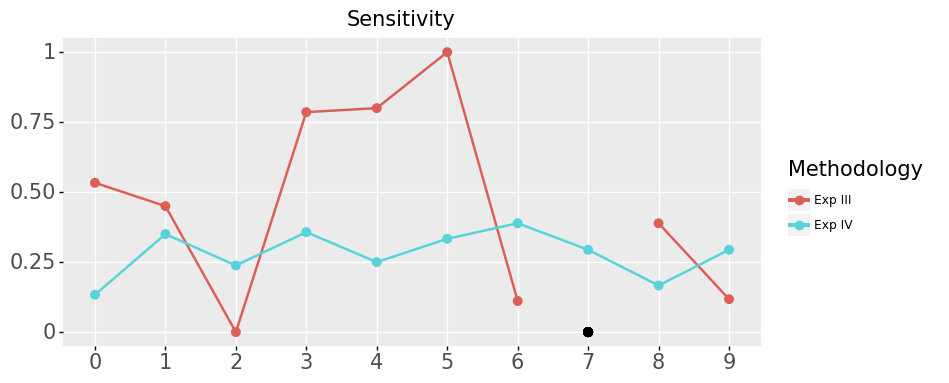

In [51]:
# p9.options.figure_size = (9, 4)
p9.options.figure_size = (9, 4)
p = ggplot(df_sen_esp, aes(x= "fold")) \
    + geom_point(aes(color = "Method", y= "sensitivity"), size = 3 ) \
    + theme(axis_text_x = element_text(size = 15),
            axis_title_x= element_blank(),
            axis_text_y = element_text(size = 15),
            axis_title_y= element_blank(),
            title = element_text(size = 15)) \
    + geom_line(aes(color = "Method", y= "sensitivity"), size = 1) \
    + geom_point(aes(x= 7, y = 0), size = 3)\
    + scale_x_continuous(breaks= range(10)) \
    + labs(color = "Methodology\n", guide = False) \
    + scale_fill_manual(values = ["#FFDDDD","#CCEEFF"], guide = False) \
    + theme(panel_grid_minor = element_blank())  \
    + labs(title = "Sensitivity")
#             legend_position = (1, 0.5))

p.save("./Graphics/new/Sensitivity.png")
p.draw(show=False, return_ggplot=True);

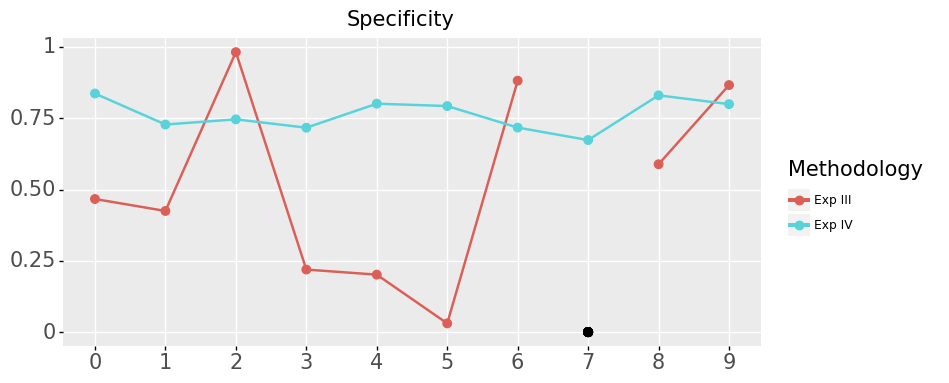

In [52]:
p9.options.figure_size = (9, 4)
p = ggplot(df_sen_esp, aes(x= "fold")) \
    + geom_point(aes(color = "Method", y= "specificity"), size = 3 ) \
    + theme(axis_text_x = element_text(size = 15),
            axis_title_x= element_blank(),
            axis_text_y = element_text(size = 15),
            axis_title_y= element_blank(),
            title = element_text(size = 15)) \
    + geom_line(aes(color = "Method", y= "specificity"), size = 1) \
    + geom_point(aes(x= 7, y = 0), size = 3)\
    + scale_x_continuous(breaks= range(10)) \
    + labs(color = "Methodology\n", guide = False) \
    + scale_fill_manual(values = ["#FFDDDD","#CCEEFF"], guide = False) \
    + theme(panel_grid_minor = element_blank())\
    + labs(title = "Specificity")
#             legend_position = (1, 0.5))

p.save("./Graphics/new/Specificity.png")
p.draw(show=False, return_ggplot=True);